In [ ]:
#ANIKET KHEDKAR & JACOB FERGUSON#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import joblib
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 1. Data Loading and Initial Exploration
# --------------------------------------
print("Loading and preparing dataset...")
df = pd.read_csv('Data.csv')

# Clean column names
df.columns = [col.strip() for col in df.columns]

# Initial checks
print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")


Loading and preparing dataset...

Dataset Info:
Shape: (452088, 11)

Missing Values:
Journey_day          0
Airline              0
Flight_code          0
Class                0
Source               0
Departure            0
Total_stops          0
Destination          0
Duration_in_hours    0
Days_left            0
Fare                 0
dtype: int64

Duplicate Rows: 8701


In [ ]:
# 2. Data Cleaning and Feature Engineering
# ----------------------------------------
print("\nPerforming data cleaning and feature engineering...")

# Handle duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Convert 'Total_stops' to numerical
df['Total_stops'] = df['Total_stops'].map({'1-stop': 1, '2+-stop': 2, 'non-stop': 0}).fillna(1)

# Extract airline code from Flight_code
df['Airline_Code'] = df['Flight_code'].str.split('-').str[0]

# Convert days to cyclical features
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Journey_day_num'] = df['Journey_day'].map({day: i for i, day in enumerate(days_order)})

# Create weekend feature
df['is_weekend'] = df['Journey_day'].isin(['Saturday', 'Sunday']).astype(int)

# Create route feature
df['Route'] = df['Source'] + '-' + df['Destination']

# Time-based features
df['Departure_Time'] = df['Departure'].str.replace(' ', '_').map({
    'Before_6_AM': 0,
    '6_AM_-_12_PM': 1,
    '12_PM_-_6_PM': 2,
    'After_6_PM': 3
}).fillna(1)

# Fare per hour
df['Fare_per_hour'] = df['Fare'] / df['Duration_in_hours']


Performing data cleaning and feature engineering...


In [ ]:
# 3. Data Preprocessing
# ---------------------
print("\nSetting up preprocessing pipeline...")

# Define features
num_features = ['Duration_in_hours', 'Days_left', 'Total_stops', 'Departure_Time', 'Fare_per_hour']
cat_features = ['Airline', 'Class', 'Source', 'Destination', 'Airline_Code', 'is_weekend']

# Preprocessing transformers
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])


Setting up preprocessing pipeline...


In [ ]:

# 4. Model Development
# --------------------
print("\nPreparing models...")

# Define base models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'LightGBM': LGBMRegressor(random_state=42)
}

# Train-test split
X = df.drop(['Fare', 'Flight_code', 'Journey_day', 'Route'], axis=1)
y = np.log1p(df['Fare'])  # Log transformation for skewed target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Enhanced Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train,
                               cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())

    # Full training
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Convert from log scale
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)

    # Calculate metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)),
        'MAE': mean_absolute_error(y_test_exp, y_pred_exp),
        'R2': r2_score(y_test_exp, y_pred_exp),
        'CV RMSE': cv_rmse,
        'Model': pipeline
    }

    return metrics

# Train and evaluate models
results = {}
print("\nTraining and evaluating models...")
for name, model in models.items():
    print(f"Evaluating {name}...")
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = metrics
    print(f"  RMSE: {metrics['RMSE']:.2f}, MAE: {metrics['MAE']:.2f}, R²: {metrics['R2']:.4f}")


Preparing models...

Training and evaluating models...
Evaluating Random Forest...
  RMSE: 189.49, MAE: 28.93, R²: 0.9999
Evaluating Gradient Boosting...
  RMSE: 3701.66, MAE: 2038.92, R²: 0.9672
Evaluating XGBoost...
  RMSE: 754.14, MAE: 389.32, R²: 0.9986
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 283767, number of used features: 45
[LightGBM] [Info] Start training from score 9.686588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train 

In [ ]:
# 5. Hyperparameter Tuning
# ------------------------
print("\nOptimizing best model with hyperparameter tuning...")

# Tune XGBoost (typically performs well)
xgb_params = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

grid_search = GridSearchCV(xgb_pipeline, xgb_params,
                         cv=3, scoring='neg_mean_squared_error',
                         n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get best model
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
y_pred_exp = np.expm1(y_pred)

# Update results
results['XGBoost_Tuned'] = {
    'RMSE': np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_exp)),
    'MAE': mean_absolute_error(np.expm1(y_test), y_pred_exp),
    'R2': r2_score(np.expm1(y_test), y_pred_exp),
    'CV RMSE': np.sqrt(-grid_search.best_score_),
    'Model': best_xgb
}

print(f"\nBest XGBoost Parameters: {grid_search.best_params_}")


Optimizing best model with hyperparameter tuning...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Best XGBoost Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 1.0}


In [ ]:
# 6. Ensemble Modeling
# --------------------
print("\nCreating ensemble model...")

# Create voting regressor with top models
ensemble = VotingRegressor([
    ('xgb', results['XGBoost_Tuned']['Model'].named_steps['model']),
    ('lgbm', results['LightGBM']['Model'].named_steps['model']),
    ('gb', results['Gradient Boosting']['Model'].named_steps['model'])
])

ensemble_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ensemble)
])

ensemble_pipeline.fit(X_train, y_train)
y_pred = ensemble_pipeline.predict(X_test)
y_pred_exp = np.expm1(y_pred)

results['Ensemble'] = {
    'RMSE': np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_exp)),
    'MAE': mean_absolute_error(np.expm1(y_test), y_pred_exp),
    'R2': r2_score(np.expm1(y_test), y_pred_exp),
    'CV RMSE': None,
    'Model': ensemble_pipeline
}


Creating ensemble model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 650
[LightGBM] [Info] Number of data points in the train set: 354709, number of used features: 45
[LightGBM] [Info] Start training from score 9.685807


In [ ]:
# 7. Results Analysis
# -------------------
results_df = pd.DataFrame(results).T.sort_values('RMSE')
print("\nFinal Model Performance Comparison:")
print(results_df[['RMSE', 'MAE', 'R2', 'CV RMSE']])

# Feature Importance Visualization
print("\nGenerating feature importance plot...")
preprocessor.fit(X_train)
feature_names = num_features + list(preprocessor.named_transformers_['cat']
                                  .named_steps['onehot']
                                  .get_feature_names_out(cat_features))

importances = results['XGBoost_Tuned']['Model'].named_steps['model'].feature_importances_

plt.figure(figsize=(12, 8))
(pd.Series(importances, index=feature_names)
 .nlargest(20)
 .plot(kind='barh', title='Top 20 Feature Importances'))
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.close()


Final Model Performance Comparison:
                          RMSE          MAE        R2   CV RMSE
Random Forest       189.487522    28.931992  0.999914  0.004813
XGBoost_Tuned       528.270369   222.851021  0.999332  0.016197
XGBoost             754.144105   389.323519  0.998638  0.023908
LightGBM            911.573451   437.098833   0.99801  0.028427
Ensemble           1500.515008   782.439556  0.994607      None
Gradient Boosting  3701.662407  2038.923652  0.967177  0.113358

Generating feature importance plot...


In [ ]:
# 8. Model Deployment
# -------------------
print("\nSaving the best model...")
joblib.dump(ensemble_pipeline, 'flight_fare_predictor.pkl')

# Sample prediction
sample_data = X_test.iloc[:1]
prediction = np.expm1(ensemble_pipeline.predict(sample_data))
actual = np.expm1(y_test.iloc[0])

print(f"\nSample Prediction:")
print(f"Input Features:\n{sample_data}")
print(f"\nPredicted Fare: ₹{prediction[0]:.2f}")
print(f"Actual Fare: ₹{actual:.2f}")




Saving the best model...

Sample Prediction:
Input Features:
       Airline     Class     Source    Departure  Total_stops Destination  \
12872  Vistara  Business  Ahmedabad  Before 6 AM            1       Delhi   

       Duration_in_hours  Days_left Airline_Code  Journey_day_num  is_weekend  \
12872            26.8333          7           UK                6           1   

       Departure_Time  Fare_per_hour  
12872               0    1260.672374  

Predicted Fare: ₹36497.20
Actual Fare: ₹33828.00


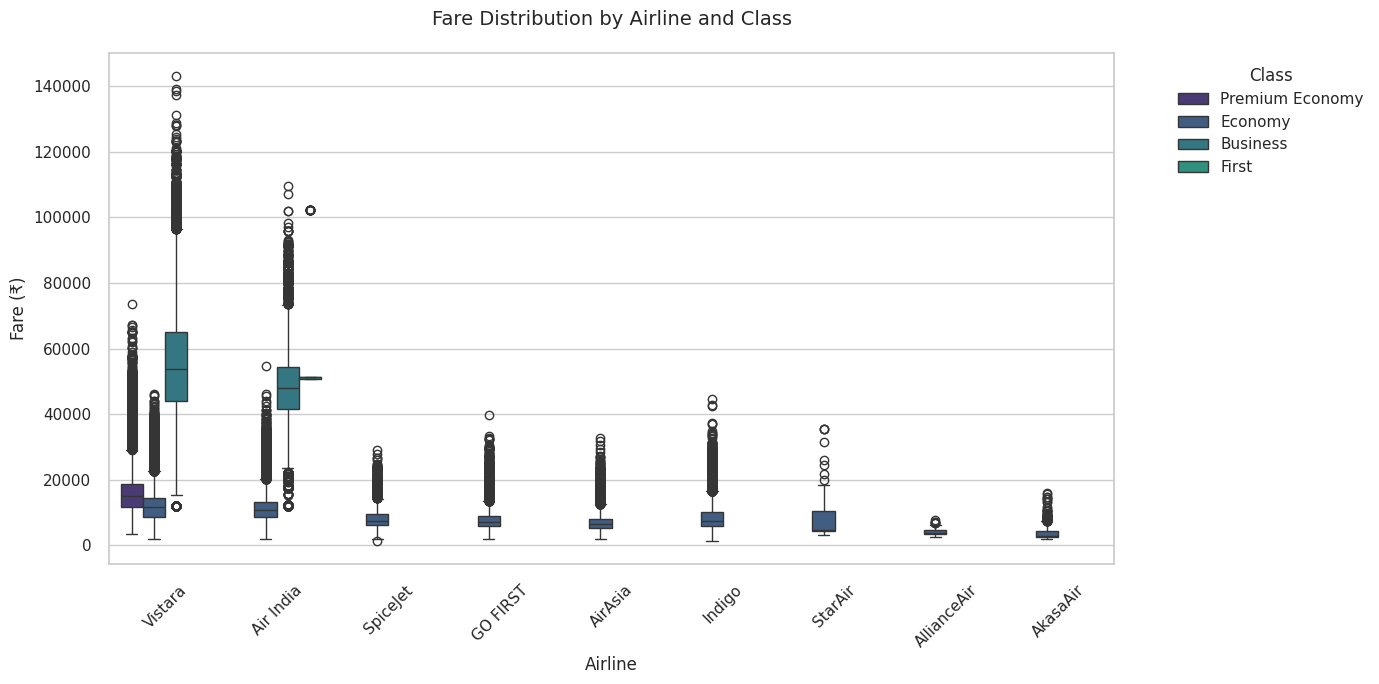

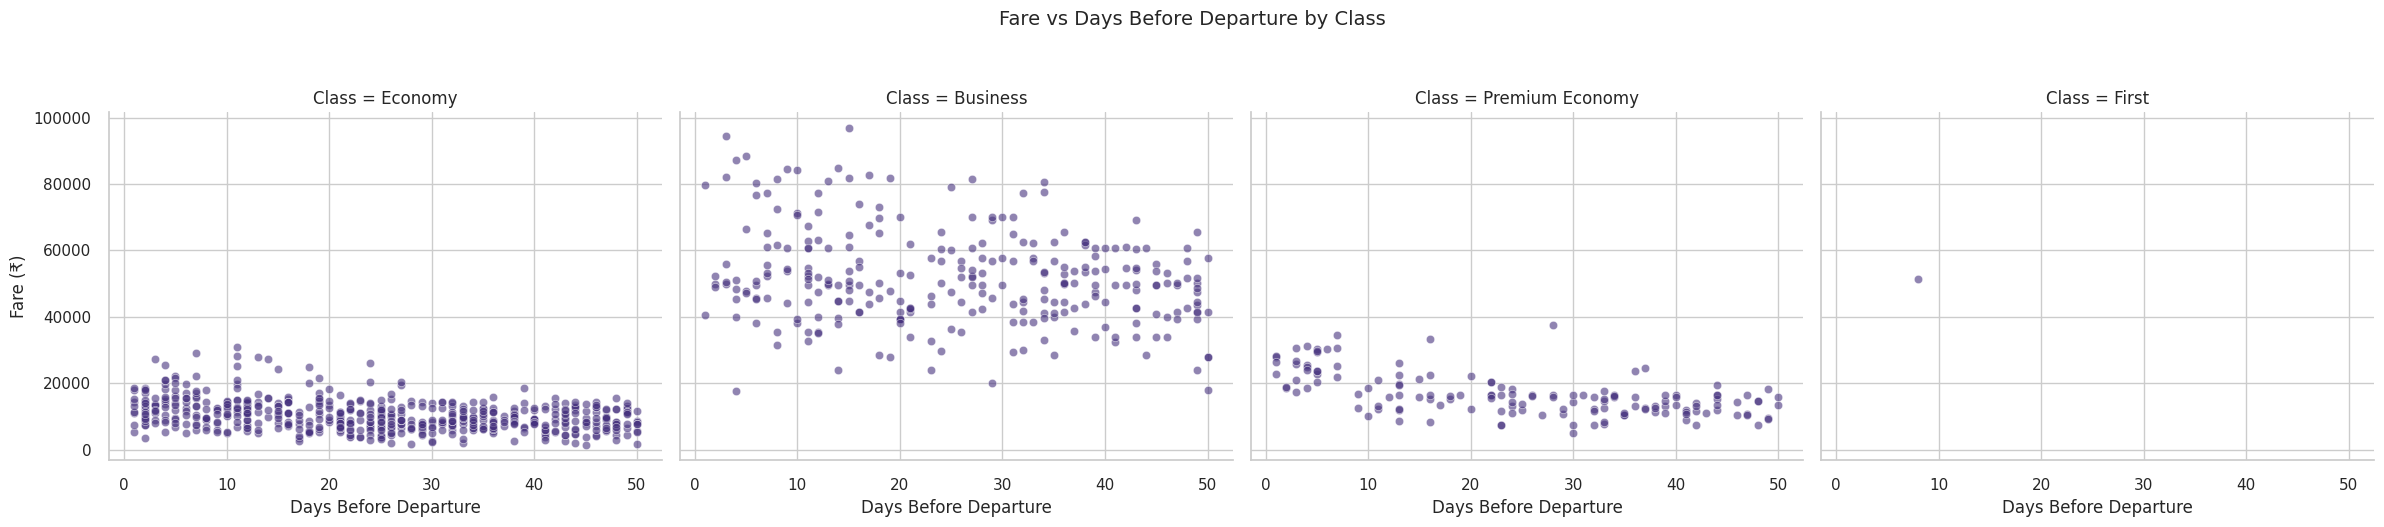

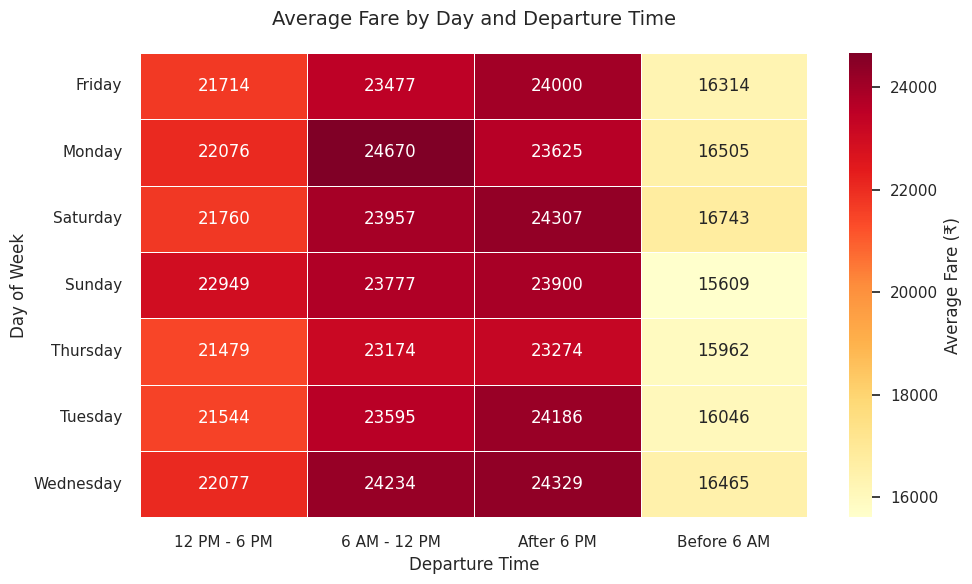

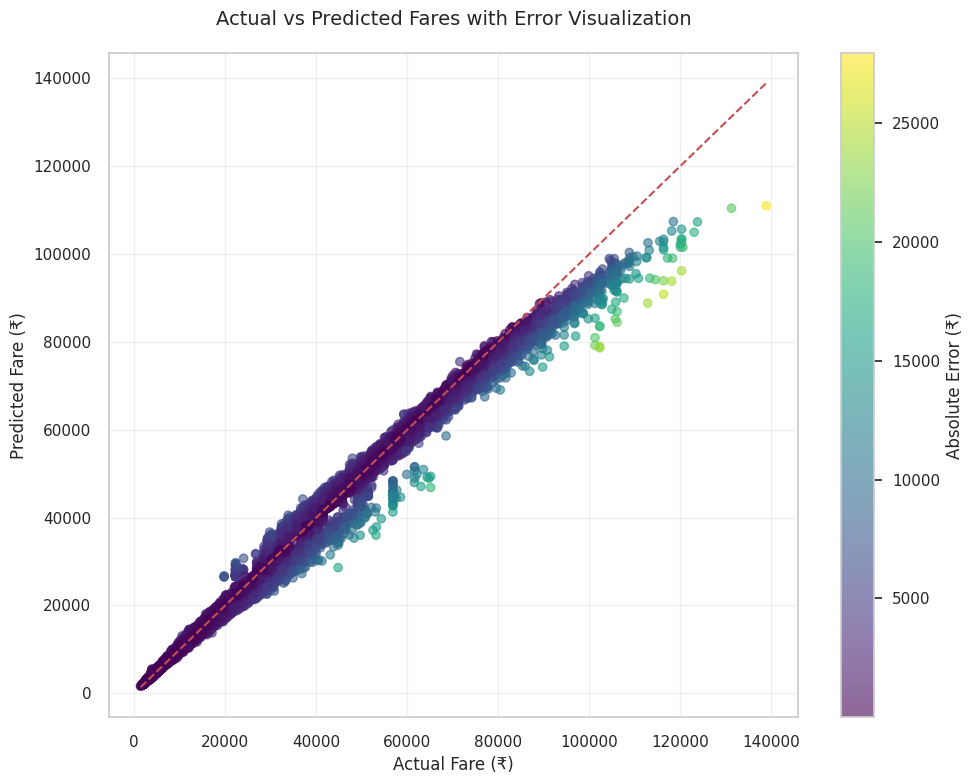

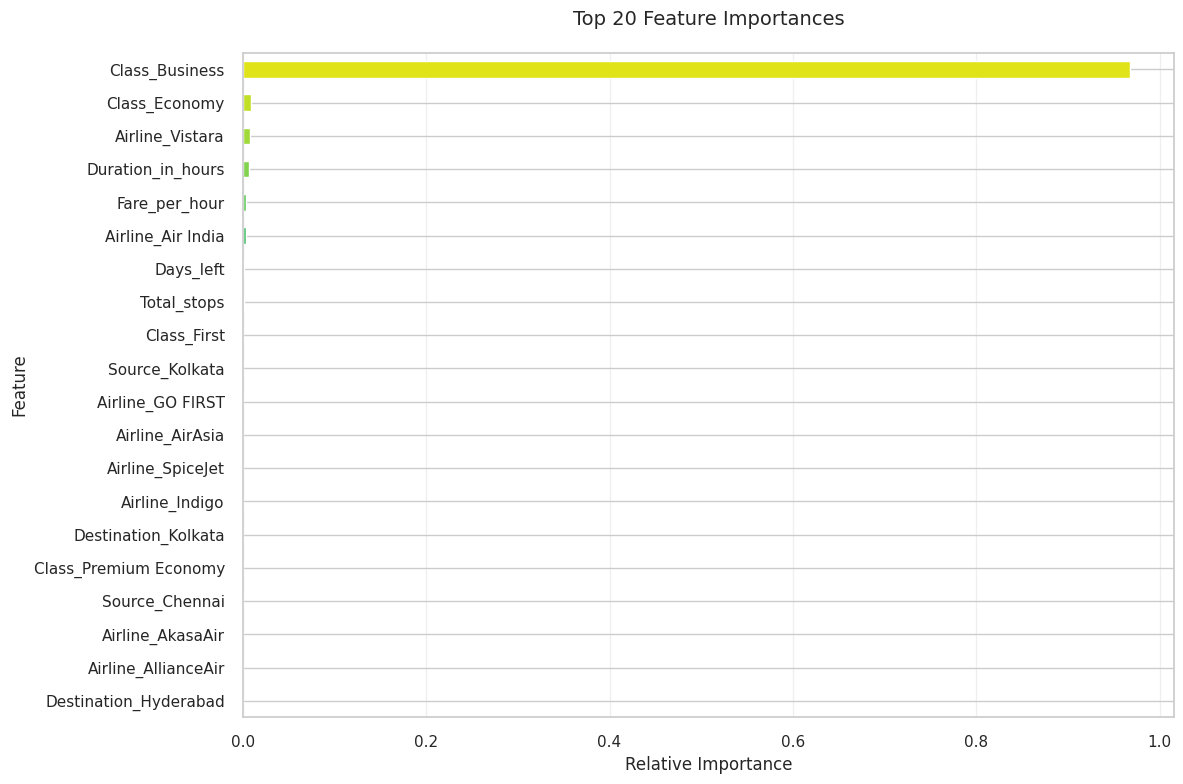

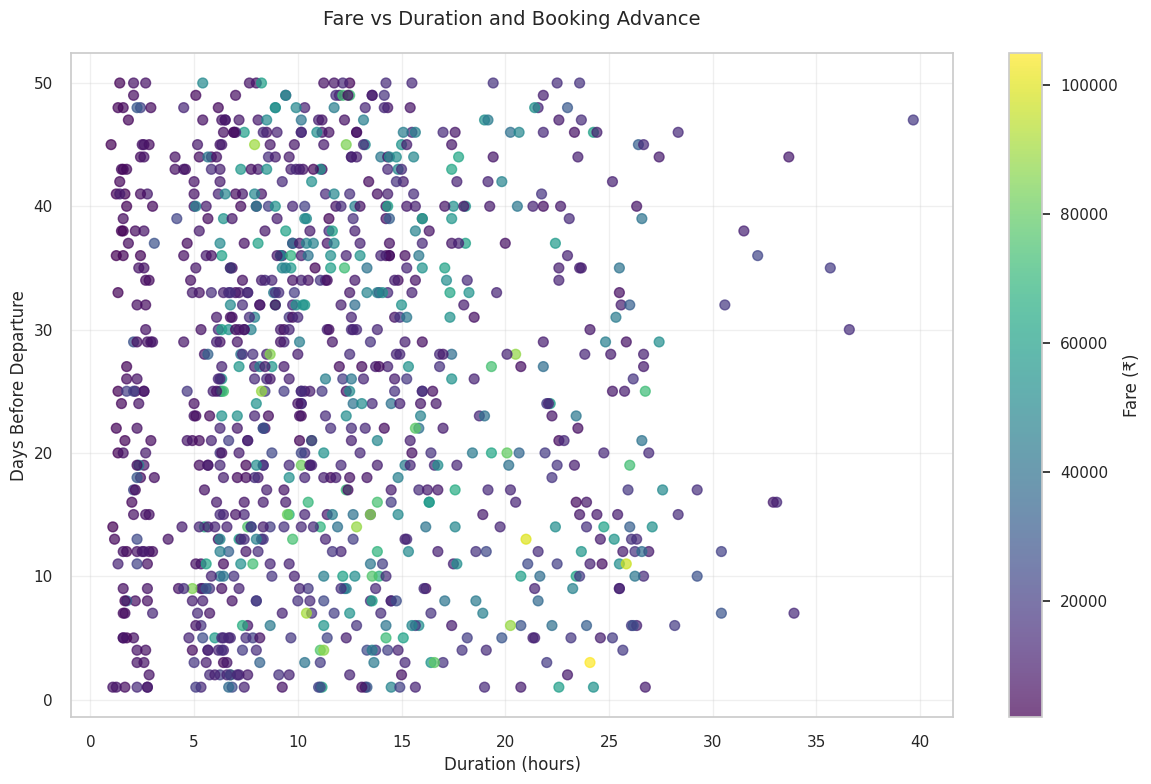

In [ ]:
#VISUALIZATION
# Corrected Interactive Visualizations for Flight Fare Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Set style for all plots (corrected style name)
plt.style.use('seaborn-v0_8')  # Updated style name
sns.set_theme(style="whitegrid")  # Using seaborn's built-in theming
sns.set_palette("viridis")

# 1. Fare Distribution by Airline and Class
plt.figure(figsize=(14, 7))
ax = sns.boxplot(x='Airline', y='Fare', hue='Class', data=df)
plt.title('Fare Distribution by Airline and Class', pad=20, fontsize=14)
plt.ylabel('Fare (₹)', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Interactive Fare vs Days Left with Class Breakdown
g = sns.FacetGrid(df.sample(1000), col='Class', height=5, aspect=1.2)
g.map(sns.scatterplot, 'Days_left', 'Fare', alpha=0.6)
g.set_axis_labels('Days Before Departure', 'Fare (₹)')
g.fig.suptitle('Fare vs Days Before Departure by Class', y=1.05, fontsize=14)
plt.tight_layout()
plt.show()

# 3. Heatmap: Average Fare by Day and Departure Time
pivot_data = df.pivot_table(values='Fare',
                           index='Journey_day',
                           columns='Departure',
                           aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="YlOrRd",
           linewidths=.5, cbar_kws={'label': 'Average Fare (₹)'})
plt.title('Average Fare by Day and Departure Time', pad=20, fontsize=14)
plt.xlabel('Departure Time', fontsize=12)
plt.ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Actual vs Predicted Fares with Error Margin
y_pred = np.expm1(ensemble_pipeline.predict(X_test))
y_true = np.expm1(y_test)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(y_true, y_pred, alpha=0.6,
                    c=np.abs(y_pred - y_true), cmap='viridis')
plt.colorbar(scatter, label='Absolute Error (₹)')
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()], 'r--')
plt.title('Actual vs Predicted Fares with Error Visualization', pad=20, fontsize=14)
plt.xlabel('Actual Fare (₹)', fontsize=12)
plt.ylabel('Predicted Fare (₹)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Feature Importance (using matplotlib instead of Plotly for compatibility)
plt.figure(figsize=(12, 8))
importance_df = (pd.Series(importances, index=feature_names)
                .nlargest(20)
                .sort_values())
importance_df.plot(kind='barh', color=sns.color_palette("viridis", len(importance_df)))
plt.title('Top 20 Feature Importances', pad=20, fontsize=14)
plt.xlabel('Relative Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. 2D version instead of 3D for better compatibility
plt.figure(figsize=(12, 8))
sample_df = df.sample(1000)
scatter = plt.scatter(x=sample_df['Duration_in_hours'],
                     y=sample_df['Days_left'],
                     c=sample_df['Fare'],
                     cmap='viridis',
                     s=50,
                     alpha=0.7)
plt.colorbar(scatter, label='Fare (₹)')
plt.title('Fare vs Duration and Booking Advance', pad=20, fontsize=14)
plt.xlabel('Duration (hours)', fontsize=12)
plt.ylabel('Days Before Departure', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

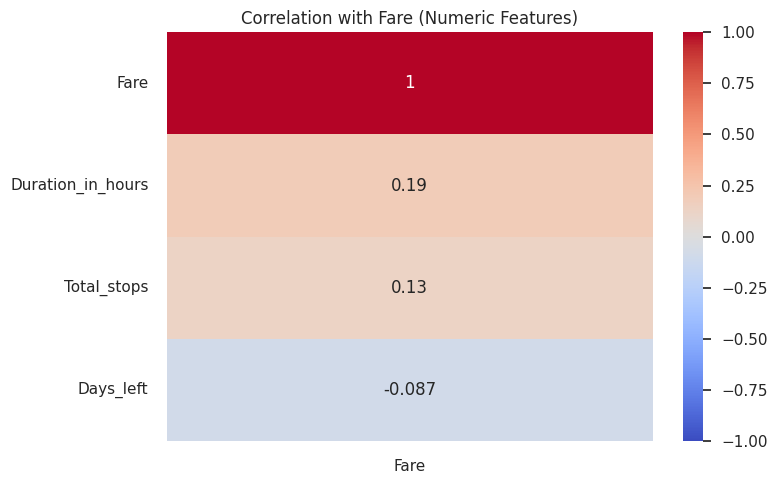

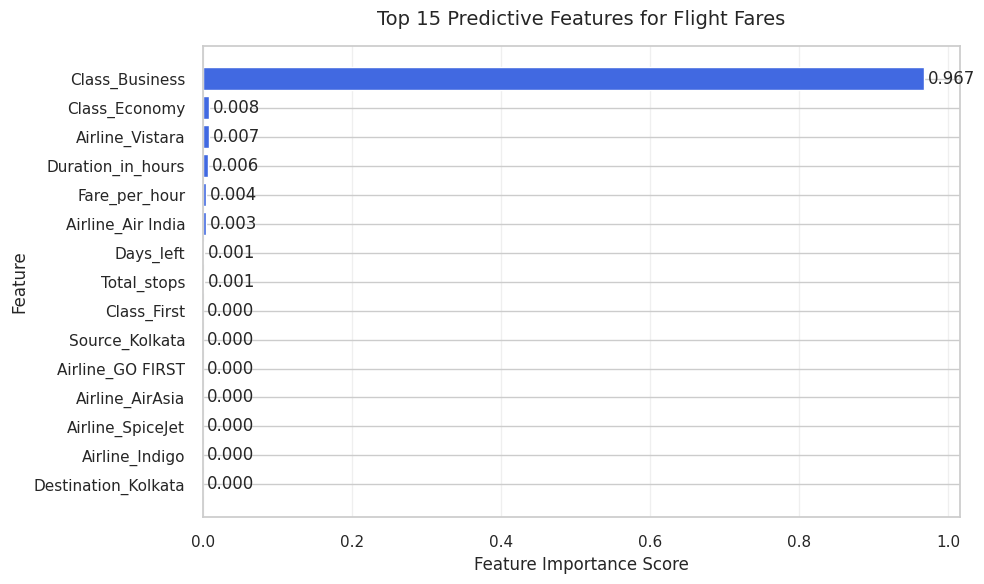

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. First let's calculate correlations with Fare for numeric features
numeric_features = ['Duration_in_hours', 'Days_left', 'Total_stops', 'Fare']
corr_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 5))
sns.heatmap(corr_matrix[['Fare']].sort_values('Fare', ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Fare (Numeric Features)')
plt.tight_layout()
plt.show()

# 2. Feature Importance Plot (using your model's importances)
plt.figure(figsize=(10, 6))

# Get feature importances from your model
importance_scores = results['XGBoost_Tuned']['Model'].named_steps['model'].feature_importances_
feature_names = num_features + list(preprocessor.named_transformers_['cat']
                                  .named_steps['onehot']
                                  .get_feature_names_out(cat_features))

# Create and sort the importance data
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
importance_df = importance_df.sort_values('Importance', ascending=False).head(15)

# Plot with improved styling
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.gca().invert_yaxis()  # Most important at top

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005,
             bar.get_y() + bar.get_height()/2,
             f'{width:.3f}',
             va='center')

# Formatting
plt.title('Top 15 Predictive Features for Flight Fares', fontsize=14, pad=15)
plt.xlabel('Feature Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

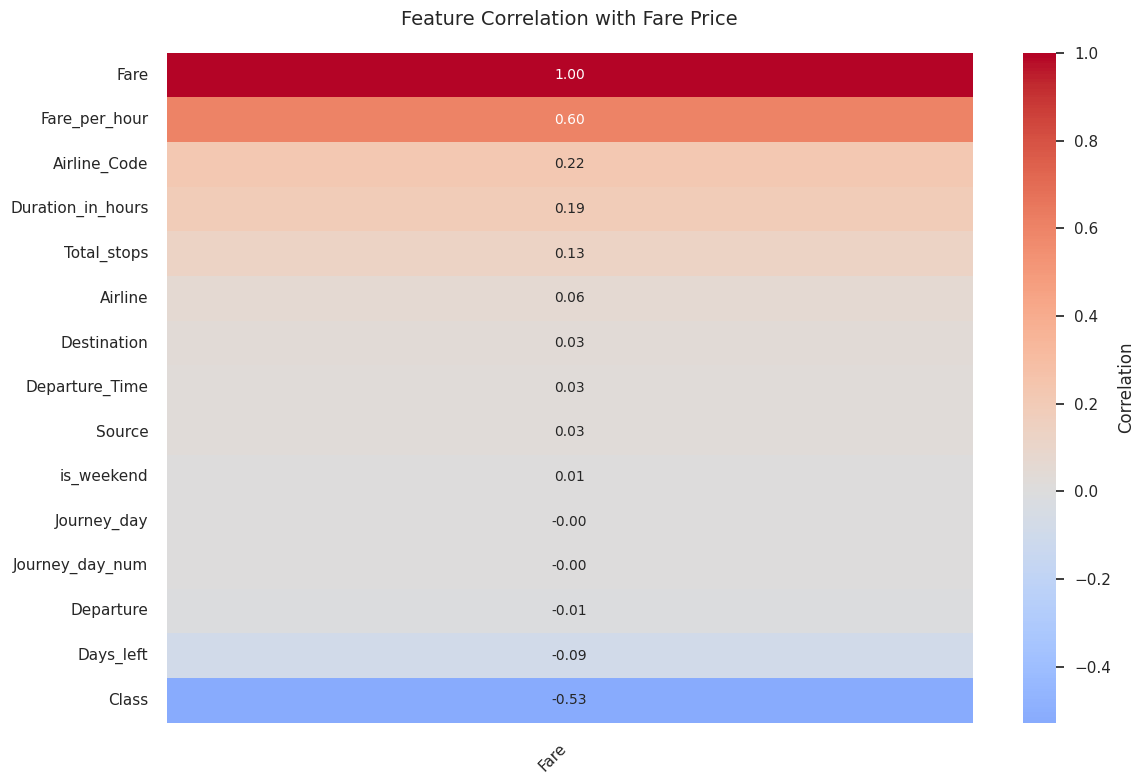

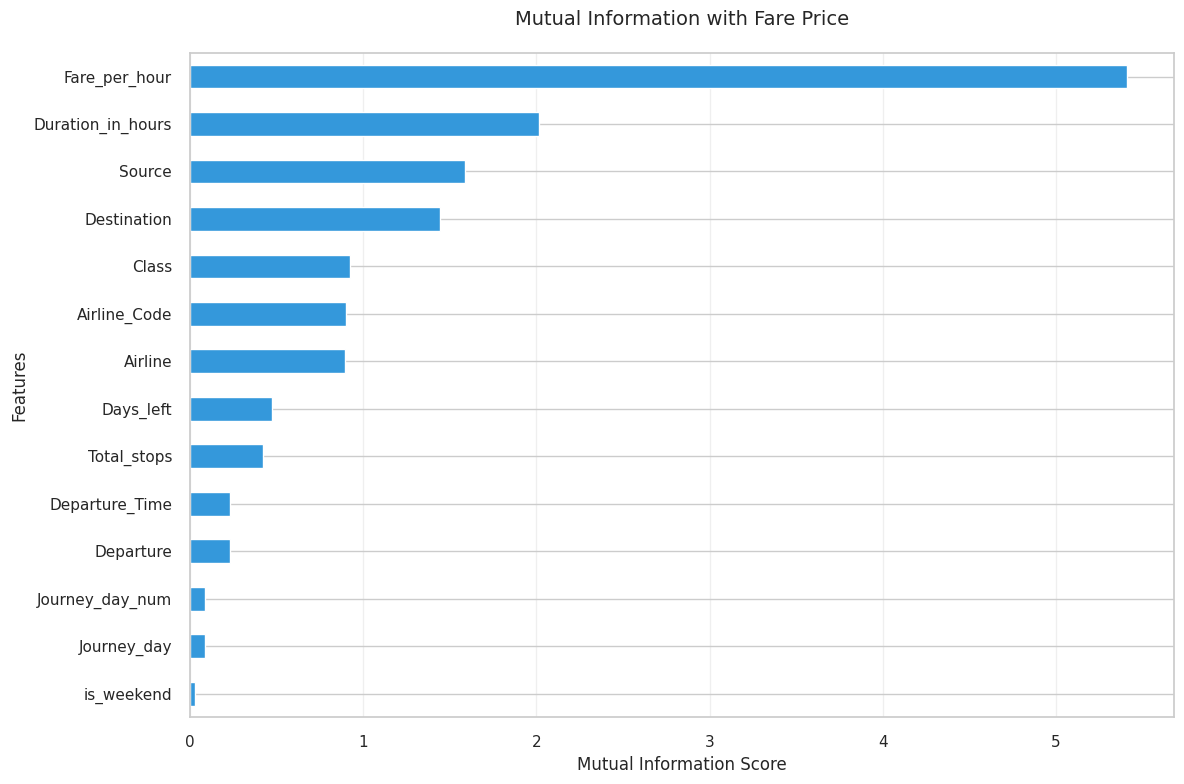

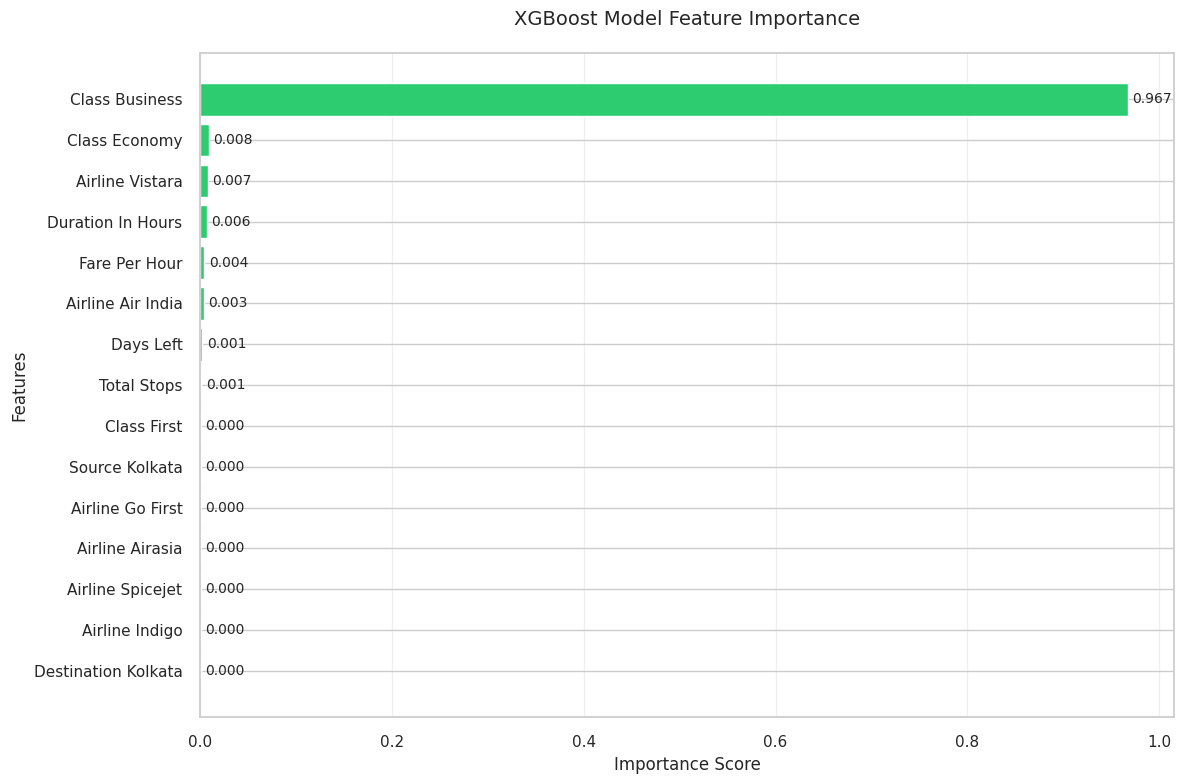

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

# 1. Prepare the data (using your existing df)
# Drop columns that won't be used in analysis
df_analysis = df.drop(['Flight_code', 'Route'], axis=1).copy()

# Convert Total_stops to numerical (if not already done)
if df_analysis['Total_stops'].dtype == 'object':
    df_analysis['Total_stops'] = df_analysis['Total_stops'].map({
        'non-stop': 0,
        '1-stop': 1,
        '2+-stop': 2
    }).fillna(1)

# 2. Correlation Analysis (with categorical encoding)
plt.figure(figsize=(12, 8))

# Label encode categorical features
cat_cols = ['Journey_day', 'Airline', 'Class', 'Source', 'Departure', 'Destination', 'Airline_Code']
df_encoded = df_analysis.copy()
for col in cat_cols:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Calculate correlation
corr_with_fare = df_encoded.corr()[['Fare']].sort_values('Fare', ascending=False)

# Plot correlation heatmap
sns.heatmap(corr_with_fare, annot=True, cmap='coolwarm', center=0,
           fmt='.2f', annot_kws={'size': 10}, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation with Fare Price', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Feature Importance Analysis
plt.figure(figsize=(12, 8))

# Calculate mutual information (alternative to correlation for non-linear relationships)
X = df_encoded.drop('Fare', axis=1)
y = df_encoded['Fare']
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False).head(15)

# Plot Mutual Information
mi_scores.sort_values().plot.barh(color='#3498db')
plt.title('Mutual Information with Fare Price', fontsize=14, pad=20)
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Model Feature Importance (using your existing XGBoost model)
plt.figure(figsize=(12, 8))

# Get feature importances from your trained model
importance_scores = results['XGBoost_Tuned']['Model'].named_steps['model'].feature_importances_
feature_names = num_features + list(preprocessor.named_transformers_['cat']
                                  .named_steps['onehot']
                                  .get_feature_names_out(cat_features))

# Create and sort importance data
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
importance_df = importance_df.sort_values('Importance', ascending=False).head(15)

# Clean feature names for display
importance_df['Feature'] = (importance_df['Feature']
                          .str.replace('_', ' ')
                          .str.replace('x0', '')
                          .str.title())

# Plot
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='#2ecc71')
plt.gca().invert_yaxis()
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', va='center', fontsize=10)
plt.title('XGBoost Model Feature Importance', fontsize=14, pad=20)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

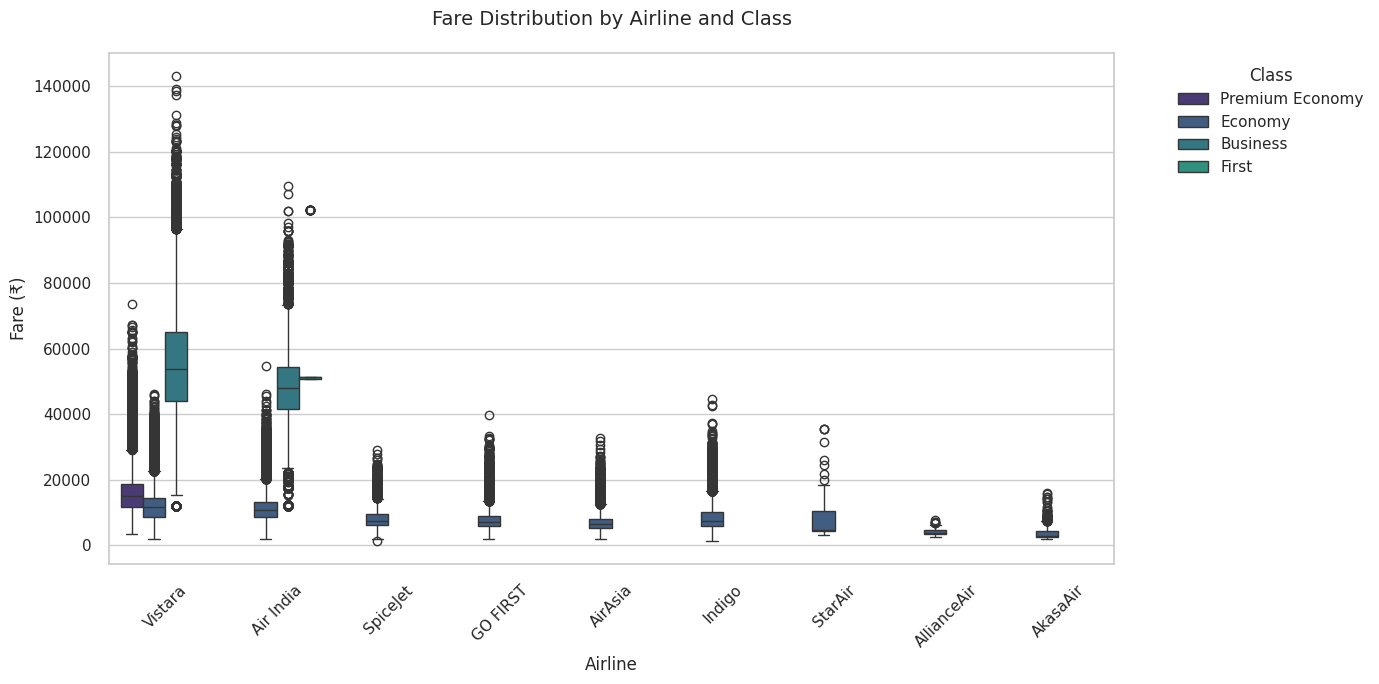

In [ ]:
# Fare Distribution by Airline and Class
plt.figure(figsize=(14, 7))
ax = sns.boxplot(x='Airline', y='Fare', hue='Class', data=df)
plt.title('Fare Distribution by Airline and Class', pad=20, fontsize=14)
plt.ylabel('Fare (₹)', fontsize=12)
plt.xlabel('Airline', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Actual vs Predicted Fares with Error Margin
y_pred = np.expm1(ensemble_pipeline.predict(X_test))
y_true = np.expm1(y_test)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(y_true, y_pred, alpha=0.6,
                     c=np.abs(y_pred - y_true), cmap='viridis')
plt.colorbar(scatter, label='Absolute Error (₹)')
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()], 'r--')
plt.title('Actual vs Predicted Fares with Error Visualization', pad=20, fontsize=14)
plt.xlabel('Actual Fare (₹)', fontsize=12)
plt.ylabel('Predicted Fare (₹)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the plot as PNG
plt.savefig('actual_vs_predicted_fares.png', dpi=300, bbox_inches='tight')
plt.close()  # Close the plot to free memory